In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn import preprocessing
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import mlflow

import logging
import pickle

import sys
from datetime import datetime

# setting path
sys.path.append('../scripts')
from preprocessing_functions import weekends, time_of_month, label_holidays, days_from_holiday


Bad key "text.kerning_factor" on line 4 in
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Load Dataset

In [2]:
logging.info('Load Training Set')

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
df_train = pd.read_csv('../data/train_clean.csv', na_values=['?', None, 'undefined'])
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,1,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,1,31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,1,31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,1,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,1,31,7,2015


In [4]:
logging.info('Load Test Set')

In [5]:
df_test = pd.read_csv('../data/test_clean.csv', na_values=['?', None, 'undefined'])
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year
0,1,1,4,2015-09-17,1.0,1,0,0,0,17,9,2015
1,2,3,4,2015-09-17,1.0,1,0,0,0,17,9,2015
2,3,7,4,2015-09-17,1.0,1,0,0,0,17,9,2015
3,4,8,4,2015-09-17,1.0,1,0,0,0,17,9,2015
4,5,9,4,2015-09-17,1.0,1,0,0,0,17,9,2015


In [6]:
logging.info('Load Store Info')

In [7]:
df_store = pd.read_csv('../data/store.csv', na_values=['?', None, 'undefined'])
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Add some more features to dataset

In [8]:
df_train['Weekend'] = df_train['DayOfWeek'].apply(weekends)
df_test['Weekend'] = df_test['DayOfWeek'].apply(weekends)

df_train['TimeOfMonth'] = df_train['Day'].apply(time_of_month)
df_test['TimeOfMonth'] = df_test['Day'].apply(time_of_month)

df_train['Holiday'] = df_train['StateHoliday'].apply(label_holidays)
df_test['Holiday'] = df_test['StateHoliday'].apply(label_holidays)

df_train['Date'] = pd.DatetimeIndex(df_train['Date'])
df_test['Date'] = pd.DatetimeIndex(df_test['Date'])


In [9]:
df_weekends = df_train[['Store', 'DayOfWeek','Open', 'Sales','Customers']]
df_weekends = df_weekends[df_weekends['Open'] == 1]
weekend_stores = df_weekends[['Store', 'DayOfWeek']].groupby('Store').nunique()
weekend_stores = weekend_stores[weekend_stores['DayOfWeek'] == 7].reset_index()
len(weekend_stores)

33

In [10]:
df_weekends = df_weekends[df_weekends['Store'].isin(set(weekend_stores['Store']))]
weekendstores = set(df_weekends['Store'])

def isallweekstore(x):
    if x in weekendstores:
        return 1
    return 0

df_train['7DayStore'] = df_train['Store'].apply(isallweekstore)
df_test['7DayStore'] = df_test['Store'].apply(isallweekstore)

In [11]:

df_store['CompetitionDistance'] = df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].max())
df_store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [12]:
df_train = df_train.merge(df_store, on='Store', how='left')
df_test = df_test.merge(df_store, on='Store', how='left')

In [18]:

holidays = np.array(df_train[df_train["Holiday"] > 1]["Date"].unique())
holidays = np.sort(holidays)

df_train["TillHday"], df_train["AfterHday"] = days_from_holiday(df_train["Date"], holidays)

holidays = np.array(df_test[df_test["Holiday"] > 1]["Date"].unique())
holidays = np.sort(holidays)
df_test["TillHday"], df_test["AfterHday"] = days_from_holiday(df_test["Date"], holidays)

In [23]:
df_train.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,Month,Year,Weekend,TimeOfMonth,7DayStore,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,TillHday,AfterHday
1003411,697,7,2013-01-13,0,0,0,0,0,0,1,13,1,2013,1,1,0,3,0,3780.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct",7,75
989237,1018,6,2013-01-26,12681,1463,1,0,0,0,1,26,1,2013,1,2,0,2,2,140.0,9.0,2012.0,0,NaN,NaN,NaN,20,62
283668,647,2,2014-11-11,6725,721,1,1,0,0,1,11,11,2014,0,1,0,0,2,7420.0,4.0,2013.0,0,NaN,NaN,NaN,10,8
335653,205,2,2014-09-16,7856,1013,1,1,0,0,0,16,9,2014,0,1,0,0,0,110.0,12.0,2007.0,0,NaN,NaN,NaN,89,17
745195,46,7,2013-09-01,0,0,0,0,0,0,1,1,9,2013,1,0,0,2,0,1200.0,9.0,2005.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",17,32


In [15]:
le = preprocessing.LabelEncoder()
df_train['StoreType'] = le.fit_transform(df_train['StoreType'])
df_train['Assortment'] = le.fit_transform(df_train['Assortment'])

df_test['StoreType'] = le.fit_transform(df_test['StoreType'])
df_test['Assortment'] = le.fit_transform(df_test['Assortment'])


In [43]:
#df_test[['Holiday','Store']].groupby('Holiday').count()
df_test[['TillHday','AfterHday']].sample(5)

,TillHday,AfterHday
19790,14,10
27033,14,2
36552,9,14
31691,4,14
6558,14,26


In [17]:
# def days_to_holiday(x, holidays):
#     upcoming_holidays = holidays[holidays >= x]
#     passed_holidays = holidays[holidays <= x]
    

# def days_to_holiday(x, holidays):
#     upcoming_holidays = holidays[holidays >= x]
#     passed_holidays = holidays[holidays <= x]

In [18]:
# holidays = pd.Series(list(set(df_train[df_train['StateHoliday'] != '0']['Date'])))

In [31]:
# train = df_train[['Store', 'DayOfWeek', 'Open', 'Promo', 'Holiday', 'SchoolHoliday', 'Day',
#               'Month', 'Year', 'Weekend' ,'TimeOfMonth', '7DayStore','StoreType',
#               'Assortment','CompetitionDistance', 'Promo2', 'TillHday', 'AfterHday', 'Sales']]
# test = df_test[['Store', 'DayOfWeek', 'Open', 'Promo', 'Holiday', 'SchoolHoliday', 'Day',
#               'Month', 'Year', 'Weekend' ,'TimeOfMonth', '7DayStore','StoreType',
#               'Assortment','CompetitionDistance', 'Promo2', 'TillHday', 'AfterHday']]
# #print(x.corr())
# train.to_csv('../data/train_final.csv')
# test.to_csv('../data/test_final.csv')

In [19]:
x = df_train[['Store', 'DayOfWeek', 'Open', 'Promo', 'Holiday', 'SchoolHoliday', 'Day',
              'Month', 'Year', 'Weekend' ,'TimeOfMonth', '7DayStore','StoreType',
              'Assortment','CompetitionDistance', 'Promo2', 'TillHday', 'AfterHday']]

y_scaler = StandardScaler()
y = y_scaler.fit_transform(df_train[['Sales']].values)
train_features = x.columns
x = x.values

### Linear Regression Pipeline with 5 fold cross validation

In [20]:

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='linear_kfold', nested = True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        reg_pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
        reg_pipe.fit(X_train, y_train)
        score = reg_pipe.score(X_test, y_test)
        mse = mean_squared_error(y_test, reg_pipe.predict(X_test))
        print("score:", score)
        print("mean squared error:", mse)
        #log model params
        mlflow.log_param("lin_reg_score", score)
        mlflow.log_param("lin_reg_mse", mse)
        # log model
        mlflow.sklearn.log_model(reg_pipe, "lin_regression_models")
        mlflow.end_run()

score: 0.5786710152268889
mean squared error: 0.4244356029283397
score: 0.5455069006117843
mean squared error: 0.4685491900245307
score: 0.5787164349995206
mean squared error: 0.4147938231180261
score: 0.528849582036513
mean squared error: 0.4828167892038149
score: 0.5467187397076403
mean squared error: 0.42698472427962325


### Random Forest Regressor Pipeline with 5 fold cross validation

In [22]:
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='random_forest_reg_kfold', nested = True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        forest_pipe = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators = 8, max_depth = 20))])
        forest_pipe.fit(X_train, y_train)
        score = forest_pipe.score(X_test, y_test)
        mse = mean_squared_error(y_test, forest_pipe.predict(X_test))
        print("score:", score)
        print("mean squared error:", mse)
        #log model params
        mlflow.log_param("rand_forest_reg_score", score)
        mlflow.log_param("rand_forest_mse", mse)
        # log model
        mlflow.sklearn.log_model(forest_pipe, "random_forest_regression_models")
        mlflow.end_run()

score: 0.9339118770450021
mean squared error: 0.06657541571205215
score: 0.9155643763102982
mean squared error: 0.08704696098198153
score: 0.9379533482182831
mean squared error: 0.06109084246897209
score: 0.9031958993261159
mean squared error: 0.09920111133754676
score: 0.9316147306324029
mean squared error: 0.06441798491046814


### Save Model

In [23]:
filename = '../models/forest-'+datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+f'-{datetime.now().microsecond}.sav'
pickle.dump(forest_pipe, open(filename, 'wb'))

In [27]:
pickle.load(open(filename, 'rb'))

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor(max_depth=20, n_estimators=8))])

### Feature importance

#### Linear Regression Model

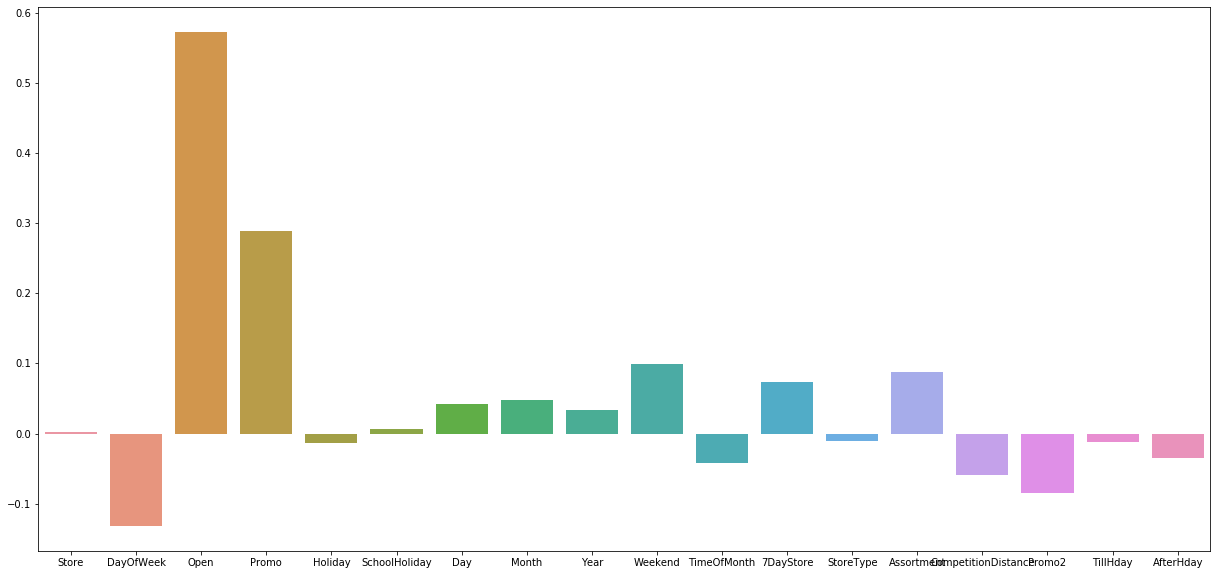

In [24]:
plt.figure(figsize=(21,10))
sns.barplot(x = train_features, y = reg_pipe[1].coef_[0])

<h5> As Day of week, time of month, distance from competition, and Promo2 increase, the sales value decreases
The most important features are whether the store was open and whether the store ran a promo. </h5>

#### Random Forest Regression Model Feature Importance

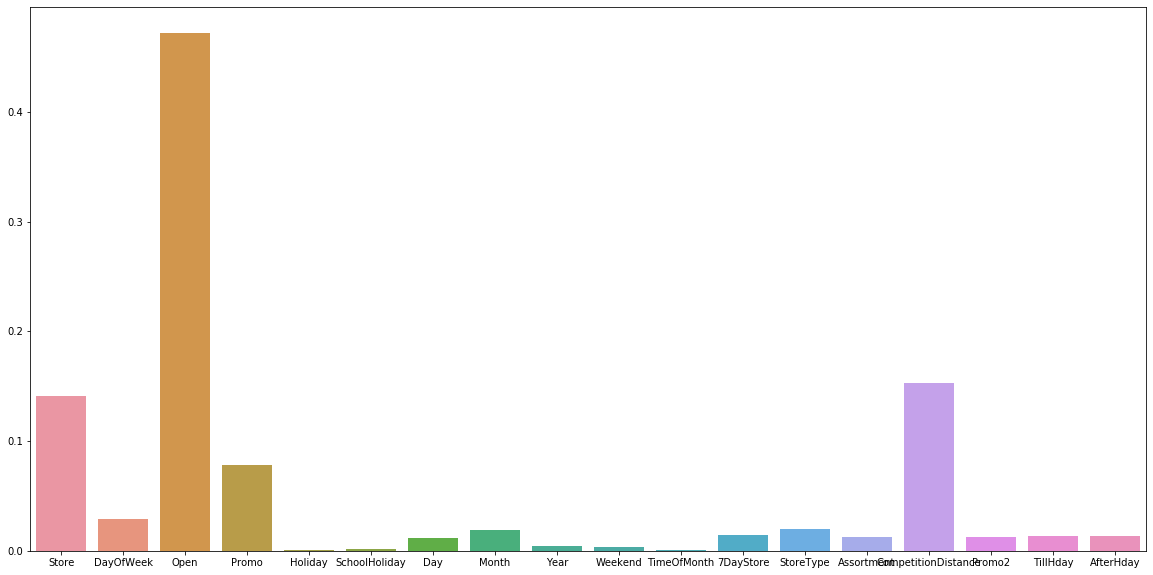

In [25]:
plt.figure(figsize=(20,10))
sns.barplot(x = train_features, y = forest_pipe[1].feature_importances_)

<h5> Here, the most important features are whether it's open, the store id, the competition distance, and whether a promo was done on that day or not <h5>